## Import Libraries 

In [1]:
import warnings
import sys
sys.path.insert(0, '../../src')
warnings.filterwarnings('ignore')

In [2]:
import ABC_train_test2
import friedman3Dataset
import network
import dataset
import sanityChecks
import torch 
import scrapbook as sb
from statistics import mean 
import catboost as ctb 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error
import numpy as np

## Parameters 

In [3]:
variance = 1
bias = 1 

In [4]:
# Parameters
variance = 0.1
bias = 0


## Dataset 


In [5]:
#Parameters 
n_features = 4
n_samples= 100
n_target = 1

In [6]:
X,Y = friedman3Dataset.friedman3_data(n_samples)

          X1           X2        X3         X4         Y
0  34.078629  1304.666015  0.343534   4.941345  1.443550
1  50.613542   401.661227  0.759427  10.421030  1.467953
2  15.209675  1701.627882  0.306439   7.293246  1.613208
3  46.472668  1656.180710  0.289889   4.370012  1.368959
4  38.097794   378.882858  0.300785  10.995740  1.371321


In [7]:
#Train test split for dataset 
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.2)
train_data = dataset.CustomDataset(X_train,Y_train)
test_data = dataset.CustomDataset(X_test,Y_test)


## Training Parameters 

In [8]:
batch_size = 32
n_epochs = 1000
#Select the device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ABC Pre-generator Model 

1. The catboost model is used as a pre-generator model for the ABC-GAN. 
2. The model is first trained on the entire dataset 
3. It generats X,Y pairs and we add some Gaussian noise with mean 0 and variance 1 to it which is then feed as input to the generator.


In [9]:
#Train the Model 
prior_model = ctb.CatBoostRegressor()
prior_model.fit(X_train,Y_train)

Learning rate set to 0.027471
0:	learn: 1.0241632	total: 60.5ms	remaining: 1m
1:	learn: 1.0149535	total: 61.7ms	remaining: 30.8s
2:	learn: 1.0042195	total: 62.6ms	remaining: 20.8s
3:	learn: 0.9946368	total: 63.6ms	remaining: 15.8s
4:	learn: 0.9854656	total: 64.4ms	remaining: 12.8s
5:	learn: 0.9771191	total: 65.3ms	remaining: 10.8s
6:	learn: 0.9660112	total: 66.3ms	remaining: 9.4s
7:	learn: 0.9559147	total: 67.1ms	remaining: 8.32s
8:	learn: 0.9466761	total: 67.6ms	remaining: 7.44s
9:	learn: 0.9365606	total: 68.2ms	remaining: 6.75s
10:	learn: 0.9281344	total: 68.7ms	remaining: 6.17s
11:	learn: 0.9188983	total: 69.2ms	remaining: 5.7s
12:	learn: 0.9086569	total: 69.9ms	remaining: 5.31s
13:	learn: 0.8996637	total: 70.5ms	remaining: 4.97s
14:	learn: 0.8896586	total: 71.1ms	remaining: 4.67s
15:	learn: 0.8825814	total: 71.6ms	remaining: 4.41s
16:	learn: 0.8730740	total: 72.2ms	remaining: 4.17s
17:	learn: 0.8653024	total: 72.8ms	remaining: 3.97s
18:	learn: 0.8561075	total: 73.3ms	remaining: 3.7

38:	learn: 0.7051463	total: 85.8ms	remaining: 2.12s
39:	learn: 0.6988331	total: 86.6ms	remaining: 2.08s
40:	learn: 0.6933144	total: 88.7ms	remaining: 2.07s
41:	learn: 0.6872018	total: 90ms	remaining: 2.05s
42:	learn: 0.6827525	total: 90.5ms	remaining: 2.01s
43:	learn: 0.6775158	total: 91.2ms	remaining: 1.98s
44:	learn: 0.6732093	total: 91.6ms	remaining: 1.94s
45:	learn: 0.6667127	total: 92ms	remaining: 1.91s
46:	learn: 0.6607598	total: 92.5ms	remaining: 1.87s
47:	learn: 0.6535290	total: 93.1ms	remaining: 1.84s
48:	learn: 0.6472870	total: 93.6ms	remaining: 1.81s
49:	learn: 0.6421112	total: 94.1ms	remaining: 1.79s
50:	learn: 0.6366539	total: 94.6ms	remaining: 1.76s
51:	learn: 0.6307933	total: 95.1ms	remaining: 1.73s
52:	learn: 0.6251795	total: 95.7ms	remaining: 1.71s
53:	learn: 0.6193234	total: 96.1ms	remaining: 1.68s
54:	learn: 0.6142242	total: 96.5ms	remaining: 1.66s
55:	learn: 0.6084328	total: 96.9ms	remaining: 1.63s
56:	learn: 0.6035247	total: 97.5ms	remaining: 1.61s
57:	learn: 0.597

194:	learn: 0.2491613	total: 157ms	remaining: 648ms
195:	learn: 0.2478585	total: 158ms	remaining: 647ms
196:	learn: 0.2466249	total: 158ms	remaining: 644ms
197:	learn: 0.2451804	total: 158ms	remaining: 642ms
198:	learn: 0.2442442	total: 159ms	remaining: 640ms
199:	learn: 0.2429213	total: 159ms	remaining: 637ms
200:	learn: 0.2415783	total: 160ms	remaining: 635ms
201:	learn: 0.2403855	total: 160ms	remaining: 633ms
202:	learn: 0.2394988	total: 161ms	remaining: 631ms
203:	learn: 0.2387698	total: 161ms	remaining: 628ms
204:	learn: 0.2379338	total: 162ms	remaining: 626ms
205:	learn: 0.2368694	total: 162ms	remaining: 624ms
206:	learn: 0.2359726	total: 162ms	remaining: 622ms
207:	learn: 0.2353833	total: 163ms	remaining: 620ms
208:	learn: 0.2341533	total: 163ms	remaining: 617ms
209:	learn: 0.2331036	total: 164ms	remaining: 616ms
210:	learn: 0.2317481	total: 164ms	remaining: 614ms
211:	learn: 0.2306292	total: 165ms	remaining: 612ms
212:	learn: 0.2292645	total: 165ms	remaining: 609ms
213:	learn: 

386:	learn: 0.1070549	total: 238ms	remaining: 377ms
387:	learn: 0.1069204	total: 239ms	remaining: 377ms
388:	learn: 0.1067888	total: 239ms	remaining: 376ms
389:	learn: 0.1066601	total: 240ms	remaining: 375ms
390:	learn: 0.1065266	total: 240ms	remaining: 374ms
391:	learn: 0.1059484	total: 241ms	remaining: 373ms
392:	learn: 0.1058258	total: 241ms	remaining: 372ms
393:	learn: 0.1057057	total: 241ms	remaining: 371ms
394:	learn: 0.1055882	total: 242ms	remaining: 370ms
395:	learn: 0.1050233	total: 242ms	remaining: 369ms
396:	learn: 0.1049089	total: 242ms	remaining: 368ms
397:	learn: 0.1047969	total: 243ms	remaining: 367ms
398:	learn: 0.1043754	total: 243ms	remaining: 366ms
399:	learn: 0.1042661	total: 244ms	remaining: 365ms
400:	learn: 0.1041592	total: 244ms	remaining: 364ms
401:	learn: 0.1037469	total: 244ms	remaining: 364ms
402:	learn: 0.1036168	total: 245ms	remaining: 363ms
403:	learn: 0.1034899	total: 245ms	remaining: 362ms
404:	learn: 0.1033761	total: 246ms	remaining: 361ms
405:	learn: 

570:	learn: 0.0703287	total: 319ms	remaining: 240ms
571:	learn: 0.0701584	total: 320ms	remaining: 240ms
572:	learn: 0.0698539	total: 321ms	remaining: 239ms
573:	learn: 0.0697724	total: 321ms	remaining: 238ms
574:	learn: 0.0696921	total: 322ms	remaining: 238ms
575:	learn: 0.0694287	total: 322ms	remaining: 237ms
576:	learn: 0.0693913	total: 323ms	remaining: 236ms
577:	learn: 0.0693543	total: 323ms	remaining: 236ms
578:	learn: 0.0692758	total: 323ms	remaining: 235ms
579:	learn: 0.0692105	total: 324ms	remaining: 234ms
580:	learn: 0.0689455	total: 324ms	remaining: 234ms
581:	learn: 0.0688202	total: 325ms	remaining: 233ms
582:	learn: 0.0684779	total: 325ms	remaining: 233ms
583:	learn: 0.0684422	total: 325ms	remaining: 232ms
584:	learn: 0.0681100	total: 326ms	remaining: 231ms
585:	learn: 0.0680482	total: 326ms	remaining: 231ms
586:	learn: 0.0677441	total: 327ms	remaining: 230ms
587:	learn: 0.0676246	total: 327ms	remaining: 229ms
588:	learn: 0.0673039	total: 328ms	remaining: 229ms
589:	learn: 

768:	learn: 0.0418561	total: 402ms	remaining: 121ms
769:	learn: 0.0418010	total: 402ms	remaining: 120ms
770:	learn: 0.0417099	total: 403ms	remaining: 120ms
771:	learn: 0.0415817	total: 403ms	remaining: 119ms
772:	learn: 0.0414920	total: 403ms	remaining: 118ms
773:	learn: 0.0414381	total: 404ms	remaining: 118ms
774:	learn: 0.0414229	total: 404ms	remaining: 117ms
775:	learn: 0.0412854	total: 405ms	remaining: 117ms
776:	learn: 0.0412378	total: 405ms	remaining: 116ms
777:	learn: 0.0411126	total: 406ms	remaining: 116ms
778:	learn: 0.0408694	total: 406ms	remaining: 115ms
779:	learn: 0.0407338	total: 407ms	remaining: 115ms
780:	learn: 0.0405987	total: 407ms	remaining: 114ms
781:	learn: 0.0404707	total: 407ms	remaining: 114ms
782:	learn: 0.0403381	total: 408ms	remaining: 113ms
783:	learn: 0.0402088	total: 408ms	remaining: 112ms
784:	learn: 0.0400356	total: 409ms	remaining: 112ms
785:	learn: 0.0400210	total: 409ms	remaining: 111ms
786:	learn: 0.0399029	total: 409ms	remaining: 111ms
787:	learn: 

961:	learn: 0.0242216	total: 481ms	remaining: 19ms
962:	learn: 0.0241883	total: 482ms	remaining: 18.5ms
963:	learn: 0.0241248	total: 482ms	remaining: 18ms
964:	learn: 0.0240242	total: 483ms	remaining: 17.5ms
965:	learn: 0.0239927	total: 483ms	remaining: 17ms
966:	learn: 0.0239070	total: 484ms	remaining: 16.5ms
967:	learn: 0.0238534	total: 484ms	remaining: 16ms
968:	learn: 0.0238447	total: 485ms	remaining: 15.5ms
969:	learn: 0.0238137	total: 485ms	remaining: 15ms
970:	learn: 0.0237609	total: 486ms	remaining: 14.5ms
971:	learn: 0.0236637	total: 486ms	remaining: 14ms
972:	learn: 0.0236330	total: 486ms	remaining: 13.5ms
973:	learn: 0.0235876	total: 487ms	remaining: 13ms
974:	learn: 0.0235574	total: 487ms	remaining: 12.5ms
975:	learn: 0.0235127	total: 488ms	remaining: 12ms
976:	learn: 0.0234687	total: 488ms	remaining: 11.5ms
977:	learn: 0.0234388	total: 489ms	remaining: 11ms
978:	learn: 0.0233955	total: 489ms	remaining: 10.5ms
979:	learn: 0.0233499	total: 490ms	remaining: 9.99ms
980:	learn:

In [10]:
y_pred = prior_model.predict(X_test)
y_abc = y_pred + np.random.normal(0,variance, y_pred.shape) + bias 
mse = mean_squared_error(y_pred,Y_test)
sb.glue("Prior Model MSE",mse)
mse = mean_squared_error(y_abc,Y_test)
sb.glue("ABC Pre-generator MSE",mse)
mae = mean_absolute_error(y_pred,Y_test)
sb.glue("Prior Model MAE",mae)
print("Prior Model MAE",mae)
mae = mean_absolute_error(y_abc,Y_test)
sb.glue("ABC Pre-generator MAE",mae)
print("ABC Pre-generator MAE",mae)

Prior Model MAE 0.298257082462791


ABC Pre-generator MAE 0.29731260002445664


# mGAN Model

In [11]:
gen = network.Generator(n_features+1).to(device)
disc = network.Discriminator(n_features+1).to(device)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(gen.parameters(), lr=0.001, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc.parameters(), lr=0.001, betas=(0.5, 0.999))

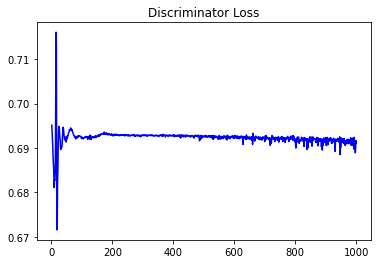

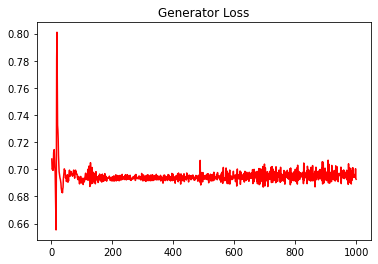

In [12]:
#Training the ABC_GAN 
ABC_train_test2.training_GAN(disc,gen,disc_opt,gen_opt,train_data,batch_size,n_epochs,criterion,prior_model,variance,bias,device)

In [13]:
ABC_GAN1_metrics=ABC_train_test2.test_generator(gen,test_data,prior_model,variance,bias,"1",device)
sb.glue("ABC_GAN_1 Metrics",ABC_GAN1_metrics)

print("MAE")
print(mean(ABC_GAN1_metrics[1]))

MAE
0.34329700702056287


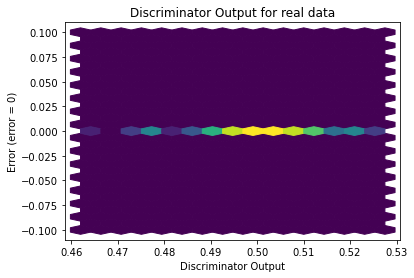

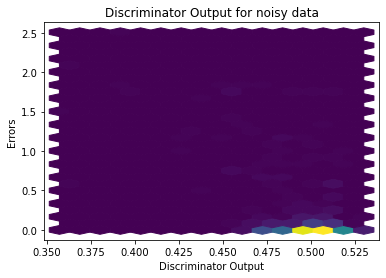

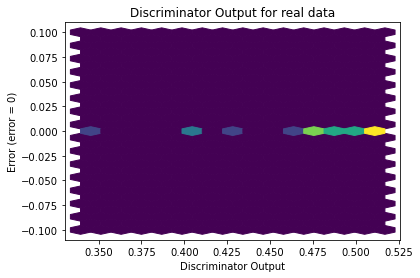

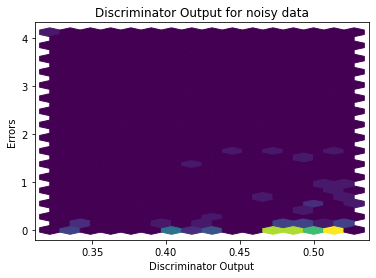

In [14]:
sanityChecks.discProbVsError(train_data,disc,device)
sanityChecks.discProbVsError(test_data,disc,device)

# mGAN Model with TabNet Generator

In [15]:
gen2 = network.GeneratorTabnet(n_features+1).to(device)
disc2 = network.Discriminator(n_features+1).to(device)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(gen2.parameters(), lr=0.001, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc2.parameters(), lr=0.001, betas=(0.5, 0.999))

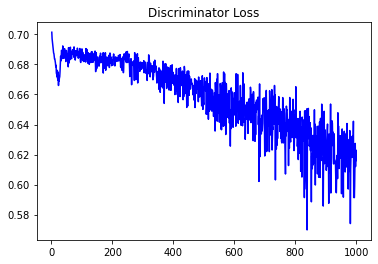

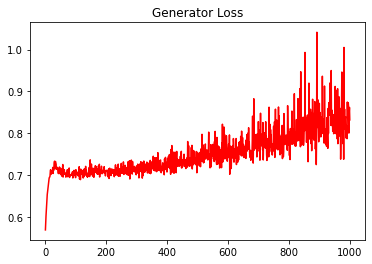

In [16]:
#Training the ABC_GAN 
ABC_train_test2.training_GAN(disc2,gen2,disc_opt,gen_opt,train_data,batch_size,n_epochs,criterion,prior_model,variance,bias,device)

In [17]:
ABC_GAN2_metrics=ABC_train_test2.test_generator(gen2,test_data,prior_model,variance,bias,"1",device)
sb.glue("ABC_GAN_2 Metrics",ABC_GAN2_metrics)

print("MAE")
print(mean(ABC_GAN2_metrics[1]))

MAE
0.4224772623870522


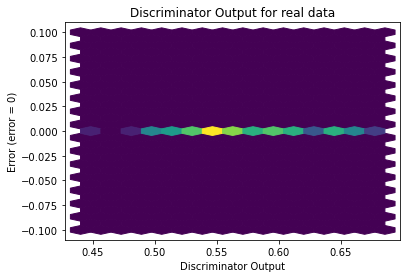

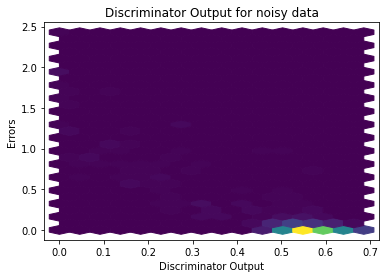

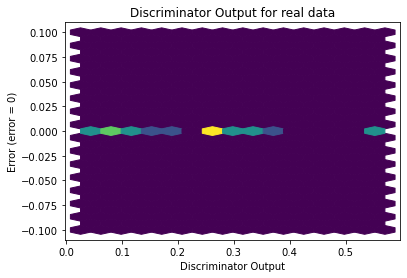

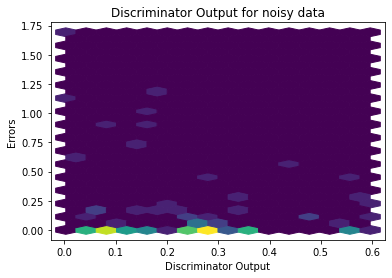

In [18]:
sanityChecks.discProbVsError(train_data,disc2,device)
sanityChecks.discProbVsError(test_data,disc2,device)

# skipGAN Model

In [19]:
#Generator
gen3 = network.GeneratorWithSkipConnection(n_features+1).to(device)
constraints=network.weightConstraint()
#Discriminator 
disc3 = network.Discriminator(n_features+1).to(device)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(gen3.parameters(), lr=0.001, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc3.parameters(), lr=0.001, betas=(0.5, 0.999))


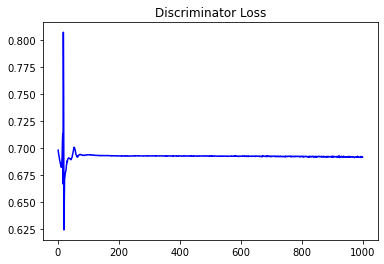

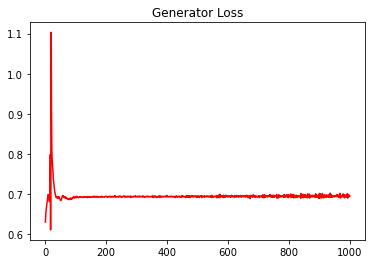

In [20]:
ABC_train_test2.training_GAN_skip_connection(disc3,gen3,disc_opt,gen_opt,train_data,batch_size,n_epochs,criterion,prior_model,variance,bias,device)

In [21]:
ABC_GAN3_metrics=ABC_train_test2.test_generator(gen3,test_data,prior_model,variance,bias,"3",device)
sb.glue("ABC_GAN_3 Metrics",ABC_GAN3_metrics)

print("MAE")
print(mean(ABC_GAN3_metrics[1]))

MAE
0.34567698385939


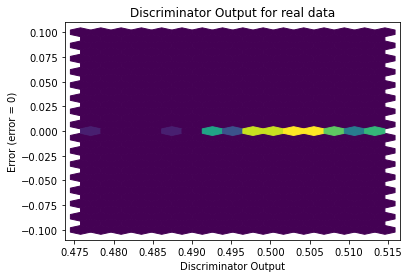

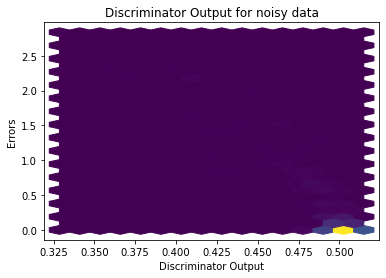

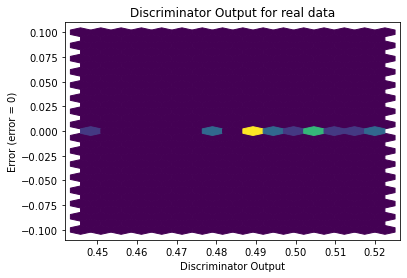

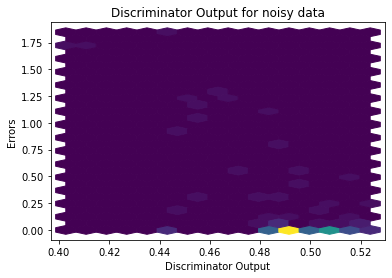

In [22]:
sanityChecks.discProbVsError(train_data,disc3,device)
sanityChecks.discProbVsError(test_data,disc3,device)

# skipGAN Model with TabNet Generator

In [23]:
#Generator
gen4 = network.GeneratorTabnetskipConnection(n_features+1).to(device)
constraints=network.weightConstraint()
#Discriminator 
disc4 = network.Discriminator(n_features+1).to(device)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(gen4.parameters(), lr=0.001, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc4.parameters(), lr=0.001, betas=(0.5, 0.999))


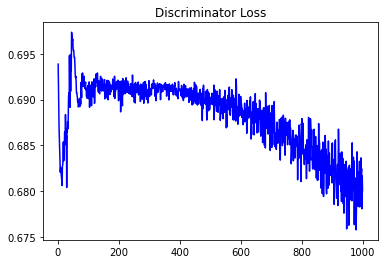

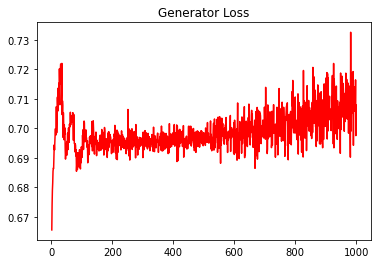

In [24]:
ABC_train_test2.training_GAN_skip_connection(disc4,gen4,disc_opt,gen_opt,train_data,batch_size,n_epochs,criterion,prior_model,variance,bias,device)

In [25]:
ABC_GAN4_metrics=ABC_train_test2.test_generator(gen4,test_data,prior_model,variance,bias,"3",device)
sb.glue("ABC_GAN_4 Metrics",ABC_GAN4_metrics)

print("MAE")
print(mean(ABC_GAN4_metrics[1]))

MAE
0.3019665550768841


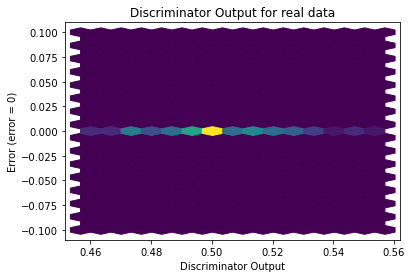

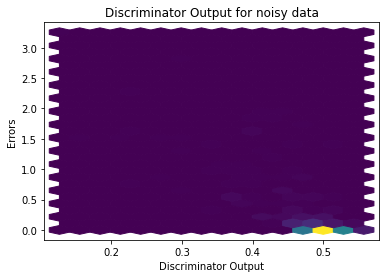

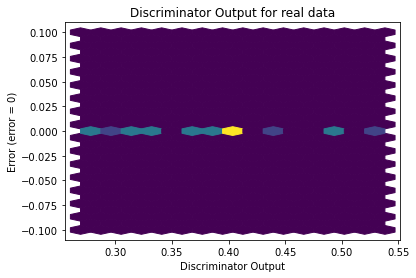

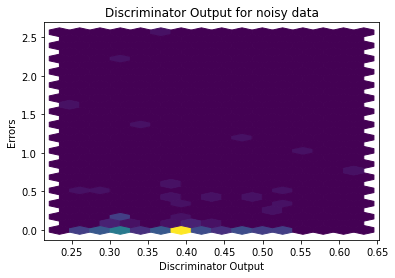

In [26]:
sanityChecks.discProbVsError(train_data,disc4,device)
sanityChecks.discProbVsError(test_data,disc4,device)

## Skip Connection Model Analysis - ABC-GAN 

### Weight Analysis 

Study the weights of the skip connection layer

Equation of the skip connection is 

$output = y_{gan} * w + y_{abc} * (1-w)$

In [27]:
print("Weight of the node at skip connection")
for name,param in gen3.named_parameters():
    if(name == "skipNode.weight"):
        print(param)
        sb.glue("Skip Connection Weight",param.item())

Weight of the node at skip connection
Parameter containing:
tensor([[0.5699]], requires_grad=True)


## skipGAN Model Analysis (TabNet Generator) 

### Weight Analysis 

Study the weights of the skip connection layer

Equation of the skip connection is 

$output = y_{gan} * w + y_{abc} * (1-w)$

In [28]:
print("Weight of the node at skip connection")
for name,param in gen4.named_parameters():
    if(name == "skipNode.weight"):
        print(param)
        sb.glue("Skip Connection Weight",param.item())

Weight of the node at skip connection
Parameter containing:
tensor([[0.0567]], requires_grad=True)
